In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [5]:
# # 从 your_data.txt 中读取数据
# with open('your_data.txt', 'r', encoding='utf-8') as file:
#     lines = file.readlines()

lines = '''股市今天大幅度上涨，投资者情绪高涨。 积极
市场出现了一些波动，投资者感到担忧。 消极
公司发布了积极的业绩报告，股价上涨。 积极
经济数据表现不佳，市场情绪疲软。 消极'''.split("\n")

In [7]:
# 分割每一行的文本和情感标签
data = [line.strip().split(' ', 1) for line in lines]
data

[['股市今天大幅度上涨，投资者情绪高涨。', '积极'],
 ['市场出现了一些波动，投资者感到担忧。', '消极'],
 ['公司发布了积极的业绩报告，股价上涨。', '积极'],
 ['经济数据表现不佳，市场情绪疲软。', '消极']]

In [8]:
# 创建DataFrame
df = pd.DataFrame(data, columns=['text', 'sentiment'])

In [9]:
df

,text,sentiment
0,股市今天大幅度上涨，投资者情绪高涨。,积极
1,市场出现了一些波动，投资者感到担忧。,消极
2,公司发布了积极的业绩报告，股价上涨。,积极
3,经济数据表现不佳，市场情绪疲软。,消极


In [10]:
# 分割数据集为训练集和测试集
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# 使用TF-IDF提取特征
tfidf_vectorizer = TfidfVectorizer()
tfidf_train_features = tfidf_vectorizer.fit_transform(train_data['text'])
tfidf_test_features = tfidf_vectorizer.transform(test_data['text'])

In [12]:
# 构建PyTorch张量
train_labels = torch.tensor([1 if sentiment == '积极' else 0 for sentiment in train_data['sentiment']])
test_labels = torch.tensor([1 if sentiment == '积极' else 0 for sentiment in test_data['sentiment']])
train_features = torch.tensor(tfidf_train_features.toarray(), dtype=torch.float32)
test_features = torch.tensor(tfidf_test_features.toarray(), dtype=torch.float32)

In [13]:
# 构建情感分类模型
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
 
    def forward(self, x):
        return self.fc(x)

In [14]:
# 初始化模型
input_dim = train_features.shape[1]
output_dim = 1
model = SentimentClassifier(input_dim, output_dim)

In [15]:
# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# 训练模型
def train(model, iterator, optimizer, criterion):
    model.train()
    for batch_features, batch_labels in iterator:  # 修改此行
        optimizer.zero_grad()
        predictions = model(batch_features)  # 修改此行
        loss = criterion(predictions.squeeze(1), batch_labels.float())
        loss.backward()
        optimizer.step()
 
# 测试模型
def evaluate(model, iterator):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_features, _ in iterator:  # 修改此行
            preds = model(batch_features).squeeze(1)  # 修改此行
            predictions.extend(torch.round(torch.sigmoid(preds)).tolist())
    return predictions

In [17]:
# 转换为PyTorch的数据加载器
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [18]:
# 训练模型
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train(model, train_loader, optimizer, criterion)

准确率: 0.00
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       1.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/opt/anaconda3/envs/ml12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ml12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ml12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/

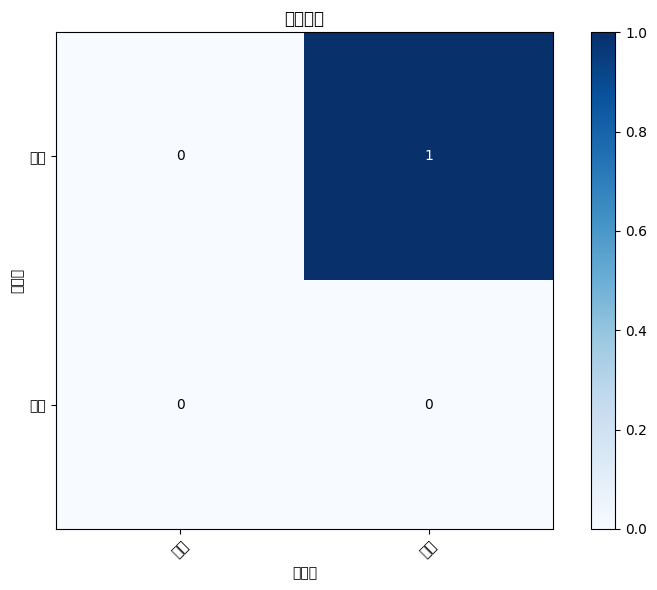

In [19]:
# 转换为PyTorch的数据加载器
test_data = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False)
 
predictions = evaluate(model, test_loader)
true_labels = test_labels.tolist()
 
# 计算准确率
accuracy = accuracy_score(true_labels, predictions)
print(f"准确率: {accuracy:.2f}")
 
# 输出分类报告
report = classification_report(true_labels, predictions)
print(report)
 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rcParams["font.sans-serif"] = ["SimHei"] # 设置字体
plt.rcParams["axes.unicode_minus"] = False # 该语句解决图像中的“-”负号的乱码问题
import matplotlib.pyplot as plt
 
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predictions)
 
# 创建一个热力图可视化混淆矩阵
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('混淆矩阵')
plt.colorbar()
 
classes = ['消极', '积极']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
 
plt.xlabel('预测值')
plt.ylabel('真实值')
 
# 在图上显示数字
thresh = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion[i, j] > thresh else "black")
 
plt.tight_layout()
plt.show()